In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

import wandb

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
df = pd.read_csv("/home/yiw/gi/train_final.csv")
df['empty'] = df.segmentation.map(lambda x: int(pd.isna(x)))
df['mask_path'] = df.mask_path.str.replace('/home/yiw/gi/input/mask/','/home/yiw/gi/input/mask/train/')

In [3]:
df2 = df.groupby(['id'])['class'].agg(list).to_frame().reset_index()
df2 = df2.merge(df.groupby(['id'])['segmentation'].agg(list), on=['id'])
# df = df[['id','case','day','image_path','mask_path','height','width', 'empty']]

df = df.drop(columns=['segmentation', 'class'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df.head()

,id,case,day,slice,image_path,height,width,mask_path,empty,class,segmentation
0,case123_day20_slice_0001,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/mask/train/case123/case123_...,1,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]"
1,case123_day20_slice_0002,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/mask/train/case123/case123_...,1,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]"
2,case123_day20_slice_0003,123,20,3,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/mask/train/case123/case123_...,1,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]"
3,case123_day20_slice_0004,123,20,4,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/mask/train/case123/case123_...,1,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]"
4,case123_day20_slice_0005,123,20,5,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/mask/train/case123/case123_...,1,"[large_bowel, small_bowel, stomach]","[nan, nan, nan]"


In [4]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('on')

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-768*768_640*704'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [256, 256]
    epochs        = 20
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-4
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [6]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   0        2655
      1        4577
1.0   0        3303
      1        5225
2.0   0        2775
      1        5161
3.0   0        2503
      1        4841
4.0   0        2849
      1        4607
Name: id, dtype: int64

In [7]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

data_transforms = {
    "train": A.Compose([
        # 256 * 256
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.CenterCrop(height=210, width=240, p=1.0),
        A.RandomResizedCrop(height=192, width=224, scale=(0.08, 1), interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=30, max_height=CFG.img_size[0]//30, max_width=CFG.img_size[1]//30,
                         min_holes=10, fill_value=0.28, mask_fill_value=0, p=0.8),
        ], p=1.0),

    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.CenterCrop(height=192, width=224, p=1.0),
        ], p=1.0)
}

def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=16, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=16, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

train_loader, valid_loader = prepare_loaders(fold=1, debug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


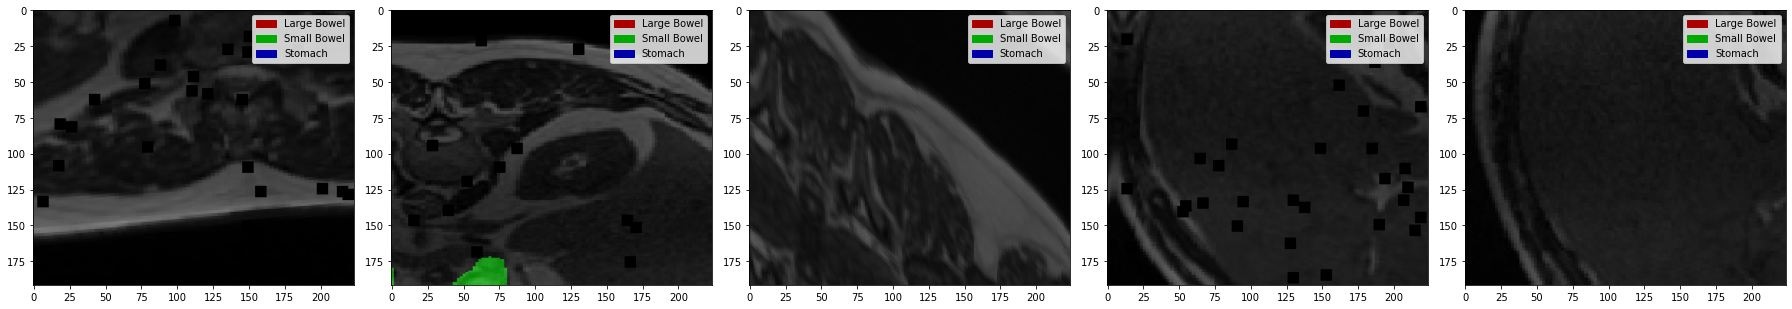

In [8]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

plot_batch(imgs, msks, size=5)

In [9]:
import gc
gc.collect()

15864

In [10]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

FocalLoss   = smp.losses.FocalLoss(mode='multilabel')

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    # return 0.2*FocalLoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true) + 0.5*JaccardLoss(y_pred, y_true)
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [11]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [12]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    # best_dice      = 0.9087
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)

        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [13]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

In [14]:
for fold in range(2, 3):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model = build_model()
    # model = load_model("/home/yiw/gi/best_epoch-02.bin")
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


###############
### Fold: 2
###############


wandb: Currently logged in as: huaiduwu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


cuda: RTX A6000

Epoch 1/20

Valid : 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, gpu_memory=14.03 GB, lr=0.00199, valid_loss=0.4661]


Valid Dice: 0.5087 | Valid Jaccard: 0.4970
Valid Score Improved (-inf ---> 0.5087)
Model Saved


Epoch 2/20

Valid : 100%|██████████| 31/31 [00:14<00:00,  2.07it/s, gpu_memory=13.98 GB, lr=0.00195, valid_loss=0.2244]


Valid Dice: 0.8128 | Valid Jaccard: 0.7802
Valid Score Improved (0.5087 ---> 0.8128)
Model Saved


Epoch 3/20

Valid : 100%|██████████| 31/31 [00:15<00:00,  2.06it/s, gpu_memory=13.98 GB, lr=0.00189, valid_loss=0.1952]


Valid Dice: 0.8455 | Valid Jaccard: 0.8150
Valid Score Improved (0.8128 ---> 0.8455)
Model Saved


Epoch 4/20

Valid : 100%|██████████| 31/31 [00:14<00:00,  2.07it/s, gpu_memory=13.98 GB, lr=0.00182, valid_loss=0.2184]


Valid Dice: 0.8134 | Valid Jaccard: 0.7848


Epoch 5/20

Valid : 100%|██████████| 31/31 [00:15<00:00,  1.95it/s, gpu_memory=13.95 GB, lr=0.00172, valid_loss=0.1799]


Valid Dice: 0.8403 | Valid Jaccard: 0.8099


Epoch 6/20

Valid : 100%|██████████| 31/31 [00:15<00:00,  2.06it/s, gpu_memory=13.95 GB, lr=0.00160, valid_loss=0.1742]


Valid Dice: 0.8607 | Valid Jaccard: 0.8309
Valid Score Improved (0.8455 ---> 0.8607)
Model Saved


Epoch 7/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, gpu_memory=13.95 GB, lr=0.00147, valid_loss=0.1795]


Valid Dice: 0.8355 | Valid Jaccard: 0.8042


Epoch 8/20

Valid : 100%|██████████| 31/31 [00:21<00:00,  1.41it/s, gpu_memory=13.96 GB, lr=0.00133, valid_loss=0.1744]


Valid Dice: 0.8431 | Valid Jaccard: 0.8117


Epoch 9/20

Valid : 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, gpu_memory=13.96 GB, lr=0.00119, valid_loss=0.1707]


Valid Dice: 0.8425 | Valid Jaccard: 0.8116


Epoch 10/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.41it/s, gpu_memory=13.96 GB, lr=0.00104, valid_loss=0.1587]


Valid Dice: 0.8597 | Valid Jaccard: 0.8292


Epoch 11/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, gpu_memory=13.99 GB, lr=0.00089, valid_loss=0.1569]


Valid Dice: 0.8731 | Valid Jaccard: 0.8435
Valid Score Improved (0.8607 ---> 0.8731)
Model Saved


Epoch 12/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.41it/s, gpu_memory=13.96 GB, lr=0.00074, valid_loss=0.1504]


Valid Dice: 0.8811 | Valid Jaccard: 0.8521
Valid Score Improved (0.8731 ---> 0.8811)
Model Saved


Epoch 13/20

Valid : 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, gpu_memory=13.99 GB, lr=0.00060, valid_loss=0.1490]


Valid Dice: 0.8717 | Valid Jaccard: 0.8420


Epoch 14/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, gpu_memory=13.99 GB, lr=0.00048, valid_loss=0.1481]


Valid Dice: 0.8773 | Valid Jaccard: 0.8475


Epoch 15/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, gpu_memory=13.99 GB, lr=0.00036, valid_loss=0.1444]


Valid Dice: 0.8815 | Valid Jaccard: 0.8521
Valid Score Improved (0.8811 ---> 0.8815)
Model Saved


Epoch 16/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.41it/s, gpu_memory=13.99 GB, lr=0.00027, valid_loss=0.1433]


Valid Dice: 0.8816 | Valid Jaccard: 0.8525
Valid Score Improved (0.8815 ---> 0.8816)
Model Saved


Epoch 17/20

Valid : 100%|██████████| 31/31 [00:21<00:00,  1.43it/s, gpu_memory=13.99 GB, lr=0.00019, valid_loss=0.1407]


Valid Dice: 0.8819 | Valid Jaccard: 0.8526
Valid Score Improved (0.8816 ---> 0.8819)
Model Saved


Epoch 18/20

Valid : 100%|██████████| 31/31 [00:21<00:00,  1.42it/s, gpu_memory=13.96 GB, lr=0.00014, valid_loss=0.1405]


Valid Dice: 0.8820 | Valid Jaccard: 0.8526
Valid Score Improved (0.8819 ---> 0.8820)
Model Saved


Epoch 19/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.40it/s, gpu_memory=13.99 GB, lr=0.00011, valid_loss=0.1397]


Valid Dice: 0.8885 | Valid Jaccard: 0.8596
Valid Score Improved (0.8820 ---> 0.8885)
Model Saved


Epoch 20/20

Valid : 100%|██████████| 31/31 [00:22<00:00,  1.37it/s, gpu_memory=13.99 GB, lr=0.00010, valid_loss=0.1410]


Valid Dice: 0.8826 | Valid Jaccard: 0.8536


Training complete in 1h 12m 4s
Best Score: 0.8596


LR,███▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁
Train Loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid Dice,▁▇▇▇▇▇▇▇▇▇██████████
Valid Jaccard,▁▆▇▇▇▇▇▇▇▇██████████
Valid Loss,█▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Best Dice,0.88848
Best Epoch,19
Best Jaccard,0.85961
LR,0.0001
Train Loss,0.12581
Valid Dice,0.8826
